In [1]:
from libs.prefect_helpers import *
from libs.data_manipulation import *
from libs.feature_generation import *
from libs.dim_reduction import *
from libs.football_plots import *
from libs.clustering import *


import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree

from mplsoccer import *
import pandas as pd
import numpy as np
import os
# Click player into the pitch and take those player and apply Ripleys K to them. And then maybe PCA


In [2]:
# Step 6: Extract match data from tracking data
data = compile_team_tracking_data("data", "Denmark")
one_match = extract_one_match(data, 1)
mean_xy = calculate_xy_mean(one_match.iloc[::48].filter(regex="^home").to_numpy())


[[ 1.88639832e+01  6.93741989e+00  1.61913834e+01 ...             nan
              nan             nan]
 [ 1.96943893e+01  8.17001247e+00  1.73564873e+01 ...             nan
              nan             nan]
 [ 2.29275932e+01  7.91264629e+00  2.23328819e+01 ...             nan
              nan             nan]
 ...
 [-2.86781490e-01 -1.49834132e+00 -2.61340809e+01 ... -1.88612080e+01
  -3.24168358e+01 -1.21793385e+01]
 [-2.70689353e-02  3.44101310e+00 -1.63819656e+01 ... -1.69635353e+01
  -2.85937996e+01 -1.29757814e+01]
 [-7.67679587e-02  6.92143583e+00 -1.20290155e+01 ... -1.63264523e+01
  -2.73052883e+01 -1.11060858e+01]]


['home_10_' 'home_12_' 'home_15_' 'home_17_' 'home_18_' 'home_19_'
 'home_1_' 'home_20_' 'home_21_' 'home_23_' 'home_2_' 'home_3_' 'home_5_'
 'home_6_' 'home_8_' 'home_9_']


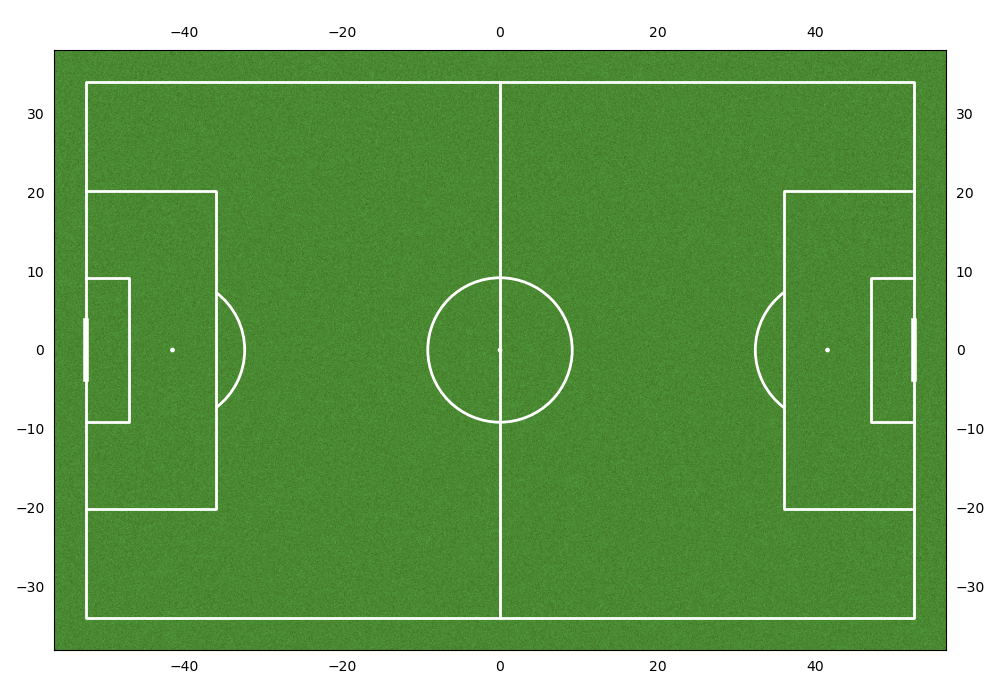

['home_15_']
['home_15_', 'home_17_']
['home_15_', 'home_17_', 'home_18_']
['home_15_', 'home_17_', 'home_18_', 'home_19_']
Cleared the current situation. You can now draw a new one.
Situation saved! Total saved situations: 1


In [3]:
%matplotlib widget
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import ipywidgets as widgets
from IPython.display import display

# Initialize plot
football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, label=True, line_color="white", pitch_color="grass")
fig, ax = football_pitch.draw(figsize=(10, 7))

# List to store points for the current situation and vectors
players =[]
points = []
vectors = []
situations = []

# Boolean to check if we're in vector drawing mode
draw_vector_mode = False
vector_start = None  # To store the start point of the vector

# Function to handle mouse clicks for points and vectors
def on_click(event):
    global vector_start, draw_vector_mode
    
    if event.inaxes:  # Check if click is inside plot
        x, y = event.xdata, event.ydata  # Get coordinates
        
        if draw_vector_mode:
            if vector_start is None:  # If no start point, set this as start point
                vector_start = (x, y)
                ax.plot(x, y, 'bo')  # Mark the start point with a blue dot
            else:
                # If there's already a start point, draw the vector from start to this point
                vector_end = (x, y)
                ax.annotate('', xy=vector_end, xytext=vector_start,
                            arrowprops=dict(facecolor='red', shrink=0.05))  # Draw vector
                vectors.append((vector_start, vector_end))  # Save the vector
                vector_start = None  # Reset the start point
        else:
            points.append((x, y))  # Add to list of points
            ax.plot(x, y, 'ro')  # Plot the point
        
        plt.draw()  # Redraw the figure

# Function to save the current situation
def save_situation(_):
    if points or vectors:
        situations.append({'points': list(points), 'vectors': list(vectors)})  # Save the current points and vectors
        print(f"Situation saved! Total saved situations: {len(situations)}")
    else:
        print("No players or vectors to save!")

# Function to clear the current situation
def clear_situation(_):
    global points, vectors, vector_start
    points = []  # Clear the current points
    vectors = []  # Clear the current vectors
    vector_start = None  # Reset vector start point
    ax.cla()  # Clear the plot
    football_pitch.draw(ax=ax)  # Redraw the empty pitch
    plt.draw()
    print("Cleared the current situation. You can now draw a new one.")

# Function to toggle vector drawing mode
def toggle_draw_vector(_):
    global draw_vector_mode
    draw_vector_mode = not draw_vector_mode  # Toggle the mode
    if draw_vector_mode:
        print("Vector drawing mode enabled. Select start and end points for the vector.")
    else:
        print("Switched to player drawing mode.")

def select_player(player_num):
    players.append(player_num)
    print(players)

def remove_player(player_num):
    try:
        players.remove(player_num)
        print(players)
    except:
        print("Player not in list")

# Create save, clear, and toggle vector buttons
save_button = widgets.Button(description="Save Situation", button_style='success')
clear_button = widgets.Button(description="Clear", button_style='warning')
toggle_vector_button = widgets.Button(description="Toggle Draw Vector", button_style='info')

#Create buttons for player filter
buttons = []
#Get unique players
players_xy = one_match.filter(regex="^home").columns.to_numpy()
player_numbers = np.array([player[:-1] for player in players_xy])
player_numbers = np.unique(player_numbers)
print(player_numbers)

for number in player_numbers:
    save_button_player = widgets.Button(description=str(number))
    undo_button = widgets.Button(description="remove player "+str(number))
    save_button_player.on_click(lambda _, n=number: select_player(n))
    undo_button.on_click(lambda _, n=number: remove_player(n))
    buttons.append(save_button_player)
    buttons.append(undo_button)
    




# Connect button click events to their functions
save_button.on_click(save_situation)
clear_button.on_click(clear_situation)
toggle_vector_button.on_click(toggle_draw_vector)
buttons.append(save_button)
buttons.append(clear_button)
buttons.append(toggle_vector_button)

# Display the buttons below the plot
display(widgets.HBox(buttons))

# Connect the click event to the handler
fig.canvas.mpl_connect('button_press_event', on_click)

plt.show()


In [5]:
regex = ""
for player in players:
    regex += "^"+player + "|"
regex = regex[:-1]

one_match = one_match.filter(regex = regex)
print(one_match.columns)

Index(['home_18_x', 'home_18_y', 'home_19_x', 'home_19_y', 'home_17_x',
       'home_17_y', 'home_15_x', 'home_15_y'],
      dtype='object')


Collected 4 points.


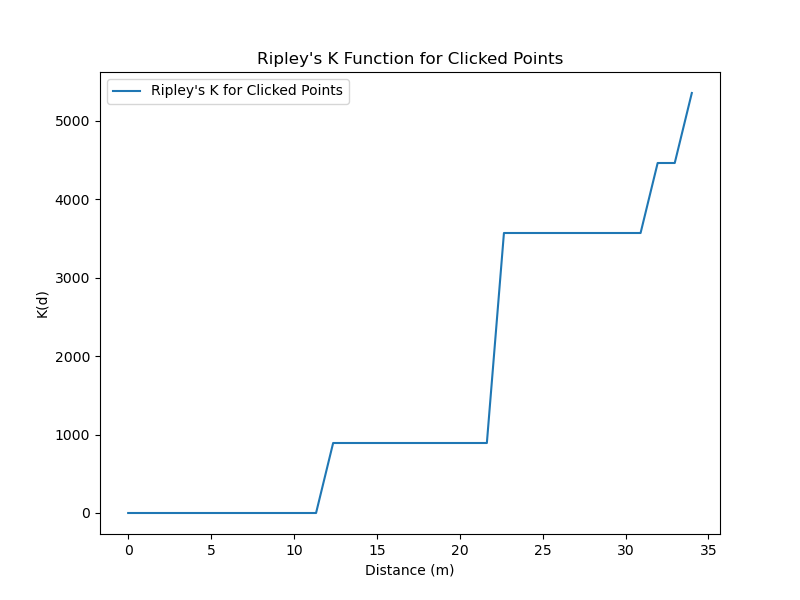

In [11]:
# Ensure the interactive pitch has captured points
if not points:
    print("Please click on the pitch to add points.")
else:
    print(f"Collected {len(points)} points.")

# Step 2: Convert the points from the interactive pitch into a usable format
points_array = np.array(points)  # Convert the collected points into a NumPy array

if points_array.shape[0] > 1:
    # Flatten the points for Ripley's K
    points_series = pd.Series(points_array.flatten())

    # Step 3: Define the radii for Ripley's K
    radii = np.linspace(0, 34, 34)  # Adjust the range based on your use case

    # Step 4: Calculate Ripley's K for the clicked points
    k_values_clicked = ripley_k(points_series, radii, width=105.0, height=68.0)

    # Step 5: Plot Ripley's K values for the clicked points
    plt.figure(figsize=(8, 6))
    plt.plot(radii, k_values_clicked, label="Ripley's K for Clicked Points")
    plt.xlabel('Distance (m)')
    plt.ylabel("K(d)")
    plt.title("Ripley's K Function for Clicked Points")
    plt.legend()
    plt.show()
else:
    print("Not enough points for Ripley's K calculation.")

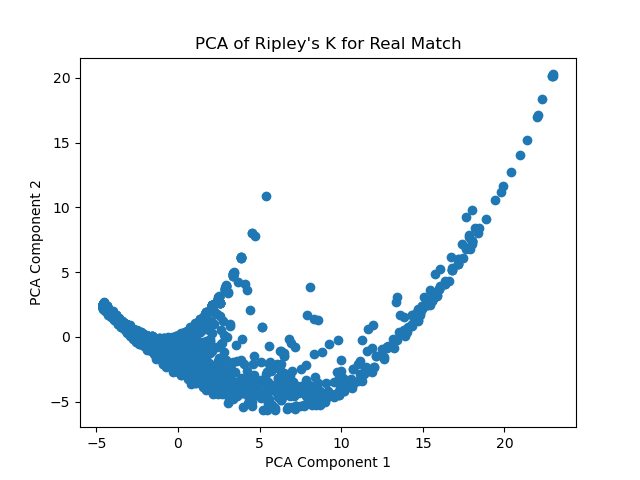

In [12]:
# Step 7: Calculate Ripley's K values for the real match data
ripley_k_vals = ripley_k_by_indices(one_match, one_match.iloc[::48].index)
ripley_k_vals = np.hstack((ripley_k_vals, mean_xy))

#Added average position of team as feature

# Step 8: Perform PCA on the Ripley's K values from the real match data
pca_obj_ripley = PCAObject(ripley_k_vals, 10)  # Fit PCA with 10 components
np_pca_ripley = pca_obj_ripley.transform(ripley_k_vals)




# Step 9: Plot the PCA-reduced Ripley's K values for the real match
plt.figure()
plt.scatter(np_pca_ripley[:, 0], np_pca_ripley[:, 1])
plt.title("PCA of Ripley's K for Real Match")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.savefig("pca_ripley.png")
plt.show()

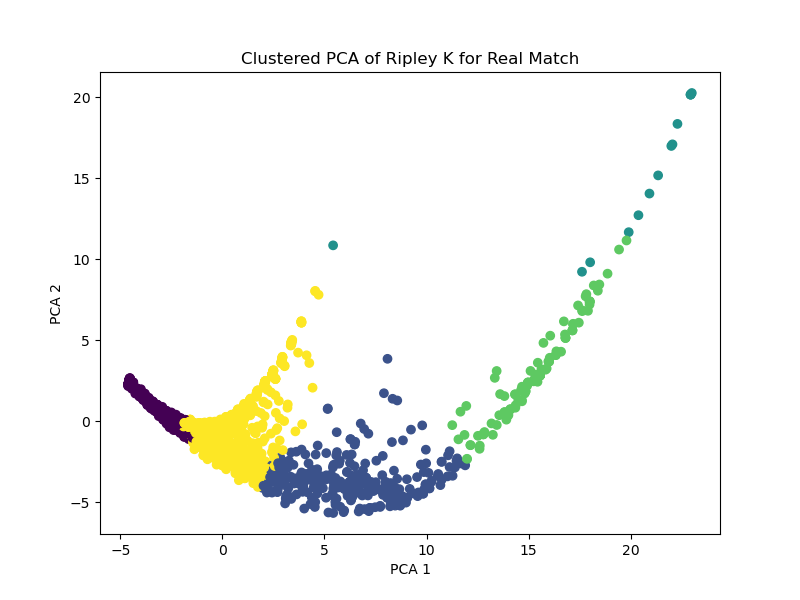

In [13]:
# Step 10: Cluster the PCA-reduced Ripley's K values using KMeans
clustering_obj_ripley = KMeansObject(np_pca_ripley, 5)  # Fit KMeans with 5 clusters
labels = clustering_obj_ripley.get_labels()

# Step 11: Plot the clustered PCA-reduced Ripley's K values
plt.figure(figsize=(8, 6))
plt.scatter(np_pca_ripley[:, 0], np_pca_ripley[:, 1], c=labels, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clustered PCA of Ripley K for Real Match')
plt.savefig("pca_ripley_clustered.png")
plt.show()

[[-12.26670768  20.49979712   6.35954986   9.47609368  -5.29769975
   -9.65700081  10.28753615  20.11966942]]


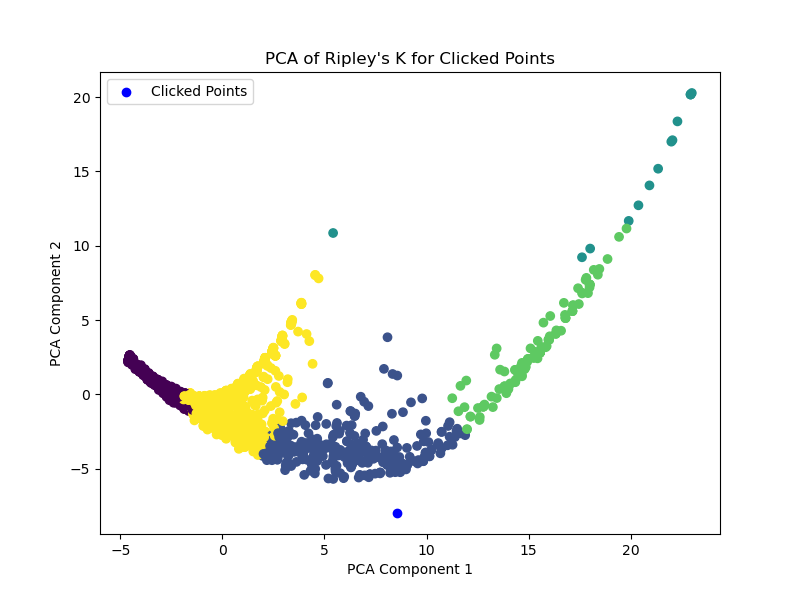

In [14]:
# Step 12: Apply PCA on the Ripley's K values for the clicked points
if points_array.shape[0] > 1:
    
    k_values_clicked_new = np.array(k_values_clicked).reshape(1, -1)  # Reshape for PCA compatibility
    xy_vals = calculate_xy_mean(points_array.flatten().reshape(1,-1))




    k_values_clicked_new = np.hstack((k_values_clicked_new, xy_vals))
  
    reduced_k_values_clicked = pca_obj_ripley.transform(k_values_clicked_new)  # Transform using the same PCA model

    # Step 13: Plot the PCA-reduced clicked points

    plt.scatter(reduced_k_values_clicked[:, 0], reduced_k_values_clicked[:, 1], c='blue', label='Clicked Points')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title("PCA of Ripley's K for Clicked Points")
    plt.legend()
    plt.show()
else:
    print("Not enough points for Ripley's K calculation.")

In [15]:
from sklearn.neighbors import KDTree

# Step 1: Build a KDTree from the PCA-reduced real match data
tree = KDTree(np_pca_ripley)

# Step 2: Query the 10 nearest neighbors for the clicked situation
distances, indices = tree.query(reduced_k_values_clicked, k=10)  # Find 10 nearest neighbors

# Flatten the indices
closest_indices = indices.flatten()
print("Closest situation indices:", closest_indices)


Closest situation indices: [1138 1858 2320 1609 1068 1611  963  610 1356  654]


In [16]:
# Assuming `one_match` is a DataFrame where each row contains player positions for a specific situation
# Each row of `one_match` contains the player positions in the format: [(x1, y1), (x2, y2), ...]

# Retrieve the 10 closest situations from the real match
closest_situations = one_match.iloc[closest_indices]


In [34]:
closest_situations

,Time [s]_team,half_team,minute_team,Period_team,home_6_x,home_6_y,home_18_x,home_18_y,home_1_x,home_1_y,...,away_5_y,away_14_x,away_14_y,away_23_x,away_23_y,away_19_x,away_19_y,ball_x,ball_y,ball_z
1158,46.32,1H,0,1,7.083072,2.276670,-5.946919,31.555954,36.763676,0.221842,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.516234,2.167463,0.204865
1167,46.68,1H,0,1,6.498189,1.890932,-6.428142,31.332726,36.449371,0.049306,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.936664,1.717647,0.211457
1159,46.36,1H,0,1,7.013314,2.220073,-5.992414,31.535280,36.733734,0.198489,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.447138,2.112289,0.198080
1160,46.40,1H,0,1,6.940545,2.167063,-6.036407,31.512997,36.701145,0.175797,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.379162,2.067157,0.207244
1161,46.44,1H,0,1,6.866704,2.118258,-6.081769,31.490099,36.666370,0.154702,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.309691,2.021635,0.213665
1164,46.56,1H,0,1,6.664420,1.995434,-6.241188,31.411343,36.553020,0.098776,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.120697,1.866008,0.210476
1163,46.52,1H,0,1,6.727523,2.032766,-6.183228,31.440874,36.591282,0.116490,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.183259,1.917115,0.209237
1166,46.64,1H,0,1,6.551818,1.924414,-6.366849,31.353123,36.482063,0.064979,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.998017,1.765162,0.211390
1162,46.48,1H,0,1,6.794523,2.073683,-6.131894,31.467525,36.629787,0.135157,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.246703,1.976494,0.207312
1165,46.60,1H,0,1,6.606501,1.959208,-6.303374,31.380947,36.516403,0.081785,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.060248,1.818266,0.208590


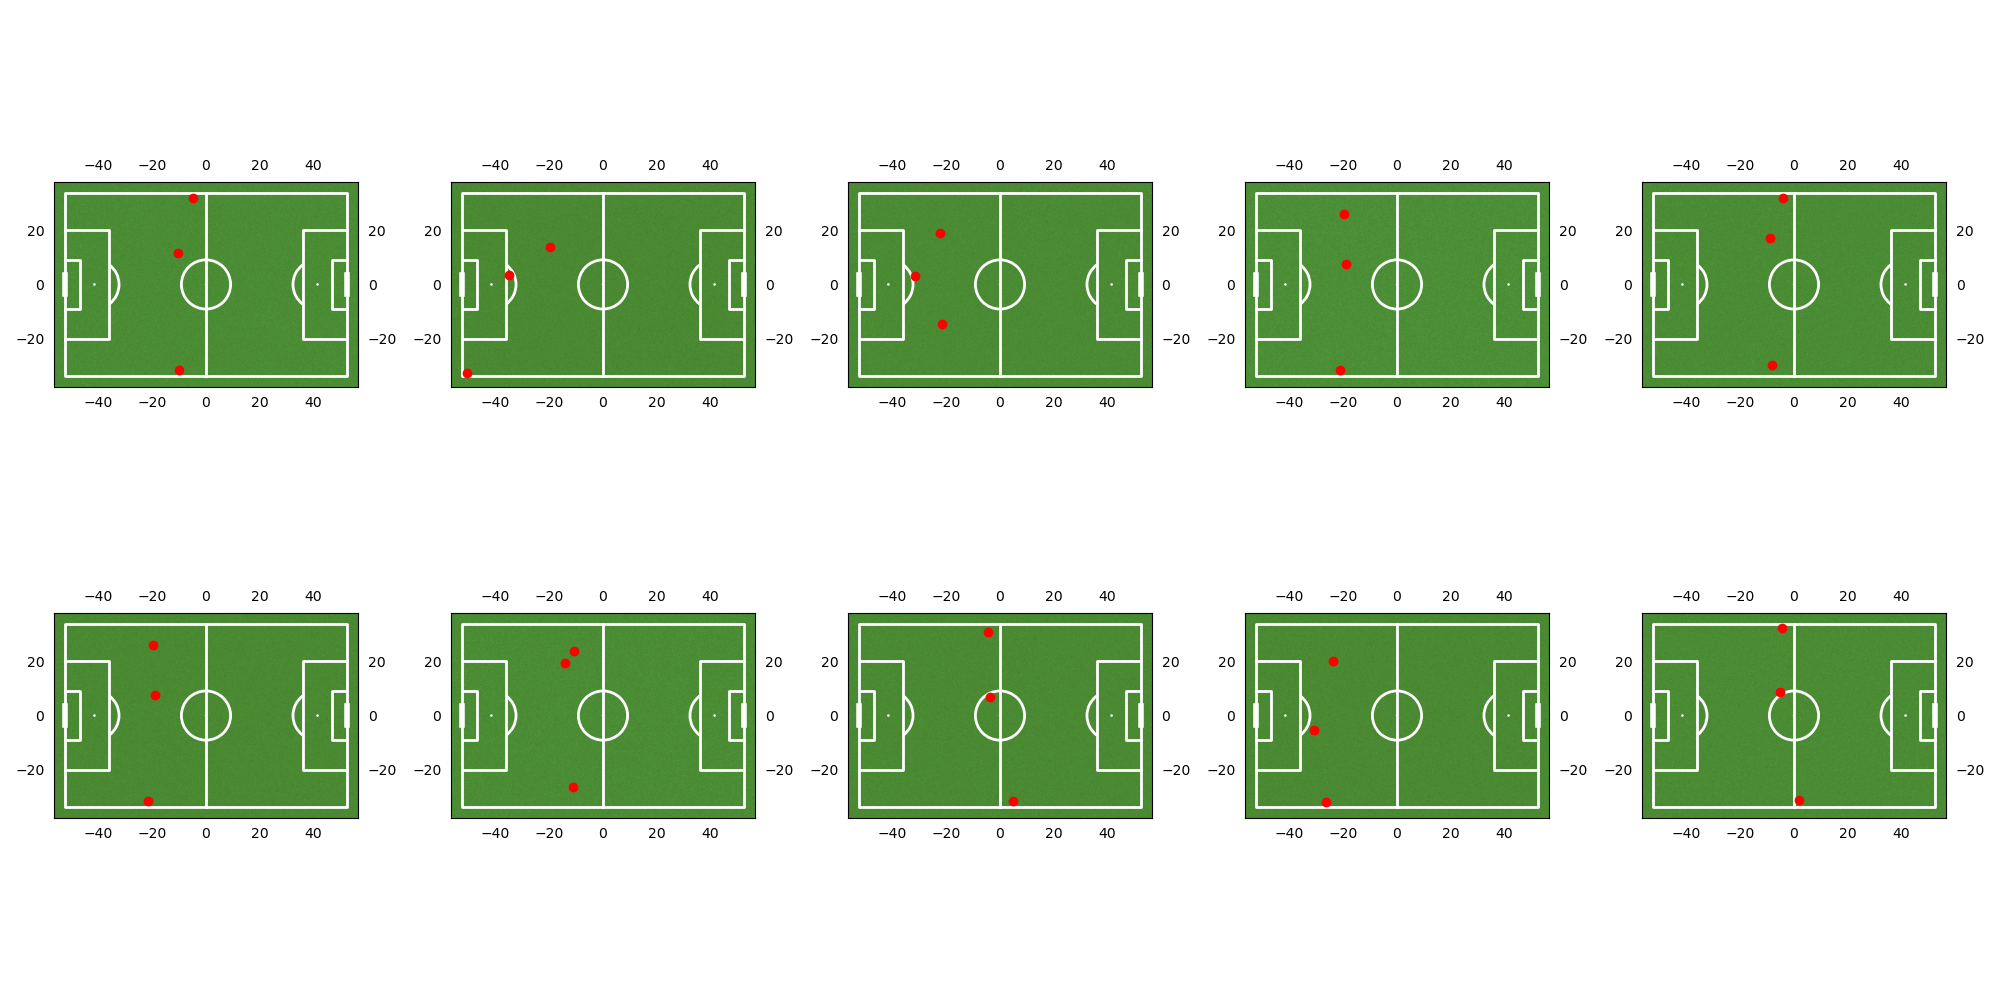

In [17]:
# Function to extract player coordinates from the DataFrame
def extract_player_positions(row):
    # Extract home player positions (x and y)
    home_x_cols = [col for col in row.index if 'home' in col and '_x' in col]
    home_y_cols = [col for col in row.index if 'home' in col and '_y' in col]
    
    home_positions = [(row[x], row[y]) for x, y in zip(home_x_cols, home_y_cols) if not pd.isna(row[x]) and not pd.isna(row[y])]

    # Extract away player positions (x and y)
    away_x_cols = [col for col in row.index if 'away' in col and '_x' in col]
    away_y_cols = [col for col in row.index if 'away' in col and '_y' in col]
    
    away_positions = [(row[x], row[y]) for x, y in zip(away_x_cols, away_y_cols) if not pd.isna(row[x]) and not pd.isna(row[y])]

    return home_positions, away_positions

# Function to plot a single situation on the pitch
def plot_situation(row, ax):
    football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, label=True, line_color="white", pitch_color="grass")
    football_pitch.draw(ax=ax)
    
    # Extract player positions from the row
    home_positions, away_positions = extract_player_positions(row)
    
    # Plot home team players (red)
    for pos in home_positions:
        ax.plot(pos[0], pos[1], 'ro')  # Mark home players as red dots

    # Plot away team players (blue)
    for pos in away_positions:
        ax.plot(pos[0], pos[1], 'bo')  # Mark away players as blue dots

# Step 4: Visualize the 10 closest situations on the pitch
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # Create a grid for 10 situations
axes = axes.flatten()

# Iterate over the 10 closest situations and plot them
for idx, situation_index in enumerate(closest_situations.index):  # Use the index of the closest situations
    plot_situation(closest_situations.loc[situation_index], axes[idx])  # Pass the row to plot_situation

plt.tight_layout()
plt.show()
